In [3]:
# For this script we didn't implemented the Kaggle correction, use only in your local machine


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import importlib
import scripts.preprocessing as preprocessing
importlib.reload(preprocessing)
import torch
import torch.nn as nn
import torchvision
import torchsummary
import torch.optim as optim
import scripts.models as models
import os
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import mlflow
import mlflow.pytorch
import torch
import scripts.utils as utils

importlib.reload(models)


<module 'scripts.models' from '/home/claudio/Scrivania/Supervised Learning/food_SSL/scripts/models.py'>

In [4]:
device = utils.use_GPU()

model = models.StormColorModel()
model.to(device);

CUDA is available!  Training on GPU ...
cuda:0


In [5]:
torchsummary.summary(model, (1, 224, 224));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]             640
         LeakyReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 16, 56, 56]           1,040
         LeakyReLU-5           [-1, 16, 56, 56]               0
       BatchNorm2d-6           [-1, 16, 56, 56]              32
            Conv2d-7           [-1, 64, 56, 56]           1,088
         LeakyReLU-8           [-1, 64, 56, 56]               0
       BatchNorm2d-9           [-1, 64, 56, 56]             128
           Conv2d-10           [-1, 64, 56, 56]           9,280
        LeakyReLU-11           [-1, 64, 56, 56]               0
      BatchNorm2d-12           [-1, 64, 56, 56]             128
        FireStorm-13          [-1, 128, 56, 56]               0
           Conv2d-14           [-1, 16,

In [6]:

# Custom class for data preparation in order to perform color recognition: 
# 1. Load the image
# 2. Convert the image to grayscale
# 3. Return the grayscale image and the original image

# transform.Normalize MUST BE COMMENTED OR DECOMMENTED INTO THIS CLASS 

class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = []
        for root, _, files in os.walk(image_folder):
            for file in files:
                if os.path.isfile(os.path.join(root, file)):
                    self.image_files.append(os.path.join(root, file))
        self.transform = transform


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        grayscale_image = transforms.functional.rgb_to_grayscale(image, num_output_channels=1)
        
        return grayscale_image, image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean= [0.6388, 0.5445, 0.4448],  std =  [0.2713, 0.2864, 0.3131]),
])


In [7]:
data_path = "./data/train"  # change if use another path

dataset = ImageDataset(image_folder=data_path, transform=transform)

print("Number of images in the dataset: ", len(dataset))
torch.manual_seed(45)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


batch_size = 16  # change if needed
num_workers = 1  # change if needed

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)   


Number of images in the dataset:  94878


In [16]:
# load mdel from disk
model = models.StormColorModel()
model.load_state_dict(torch.load('colorSSLdecoder.pth'))
model.to(device);

In [18]:
model.features[0]
pretrainedmodel = model

In [19]:
# get the state dictionary from the new model just created in this cell
state_dict = pretrainedmodel.state_dict()
np.shape(state_dict['features.0.weight'] )

torch.Size([64, 1, 3, 3])

In [20]:
# Modify the first layer's weights to handle three channels
original_weights = state_dict['features.0.weight']  # Shape: [64, 1, 3, 3]

# Create a new weight tensor with three channels
new_weights = torch.zeros((original_weights.size(0), 
                           3, 
                           original_weights.size(2), 
                           original_weights.size(3)))

# Copy the original weights to each of the three channels
new_weights[:, 0:1, :, :] = original_weights
new_weights[:, 1:2, :, :] = original_weights
new_weights[:, 2:3, :, :] = original_weights

# Replace the weights in the state dictionary
state_dict['features.0.weight'] = new_weights

In [21]:
# load netFromSSL from disk
# Load the original state dictionary
SSLmodel = models.StormModel()
SSLmodel.to(device)

# Extract the `features` part of the state dictionary and remove the "features." prefix
features_state_dict = {k.replace('features.', ''): v for k, v in state_dict.items() if k.startswith('features.')}

# Load the `features` part of the state dictionary into the new model
SSLmodel.features.load_state_dict(features_state_dict)



<All keys matched successfully>

In [22]:
torch.save(SSLmodel.state_dict(), 'StormModelPretrained.pth')

In [23]:
import matplotlib.pyplot as plt
import random

# Assuming these are the normalization parameters used during preprocessing
mean= [0.6388, 0.5445, 0.4448]
std =  [0.2713, 0.2864, 0.3131]

def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor using the provided mean and standard deviation.
    """
    tensor = tensor.clone()  # Create a copy to avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_random_test_image(model, test_dataset, denormalization=False, idx = None):
    """
    Displays a random image from the test dataset along with its grayscale, original colored,
    and reconstructed versions from the model.

    Parameters:
    - model: The trained model to use for reconstructing the image.
    - test_dataset: The dataset containing the test images.
    - denormalization: Boolean indicating whether to apply denormalization to the images.
    """
   
    model.eval()
    if idx is None:
        idx = random.randint(0, len(test_dataset) - 1)

    grayscale_image, color_image = test_dataset[idx]
    
    # Add batch dimension
    grayscale_image = grayscale_image.unsqueeze(0).to(device)
    color_image = color_image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        reconstructed_image = model(grayscale_image)
    
    # Denormalize images if required
    if denormalization:
        grayscale_image = denormalize(grayscale_image.squeeze(0).cpu(), mean, std)
        color_image = denormalize(color_image.squeeze(0).cpu(), mean, std)
        reconstructed_image = denormalize(reconstructed_image.squeeze(0).cpu(), mean, std)
    else:
        grayscale_image = grayscale_image.squeeze(0).cpu()
        color_image = color_image.squeeze(0).cpu()
        reconstructed_image = reconstructed_image.squeeze(0).cpu()
       
    # Convert to numpy for visualization
    grayscale_image = grayscale_image.numpy().transpose(1, 2, 0)
    color_image = color_image.numpy().transpose(1, 2, 0)
    reconstructed_image = reconstructed_image.numpy().transpose(1, 2, 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(grayscale_image.squeeze(), cmap='gray')
    axes[0].set_title('Grayscale image')
    axes[0].axis('off')
    
    axes[1].imshow(color_image)
    axes[1].set_title('Original colored image (SSL label)')
    axes[1].axis('off')
    
    axes[2].imshow(reconstructed_image)
    axes[2].set_title('Reconstructed image')
    axes[2].axis('off')
    
    plt.show()

    return idx, fig

# Example call to the function
# Ensure that `model` and `test_dataset` are defined before calling this function.
# show_random_test_image(model, test_dataset, denormalization=True)


Model with normalization


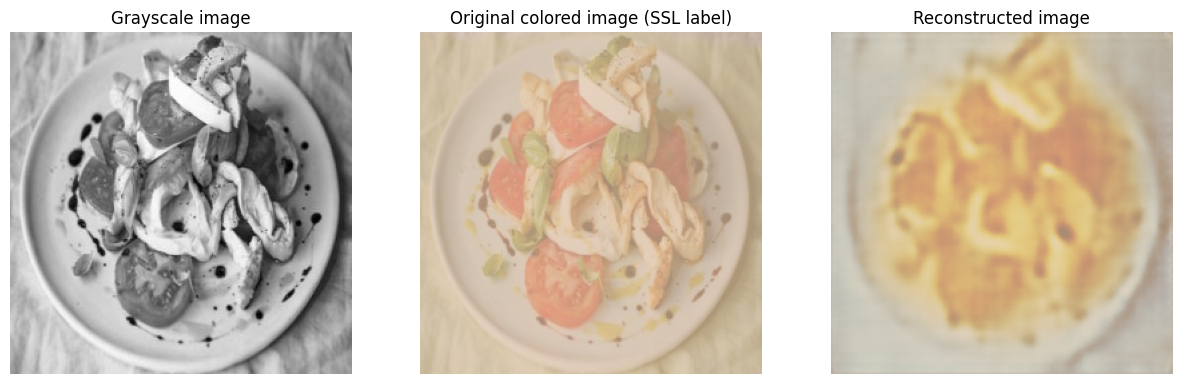

Model without normalization


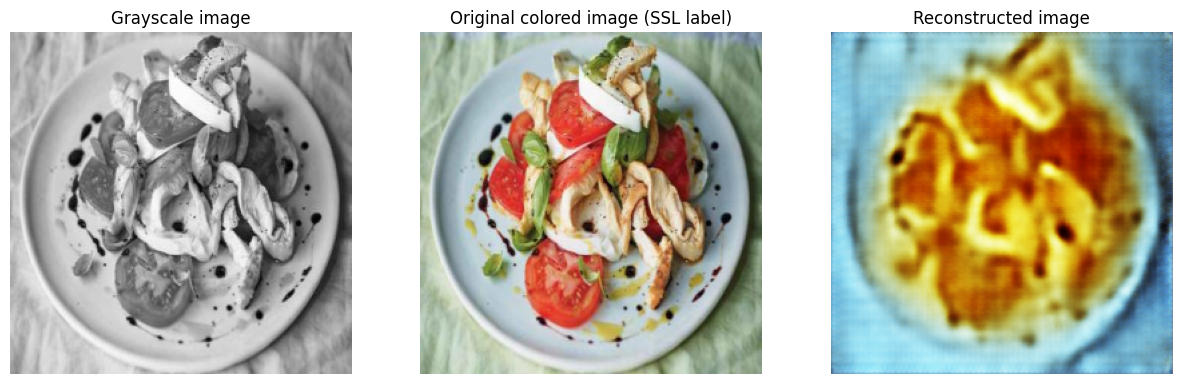

In [44]:
print("Model with normalization")
idx,fig = show_random_test_image(model, train_dataset, denormalization=True)

print("Model without normalization")
idx,fig = show_random_test_image(model, train_dataset, denormalization=False, idx=idx)

In [45]:
fig.savefig(f"figures/color_recostruction_{idx}.png")